# 11. 정규회귀의 확장

In [2]:
library(bayesrules)
library(rstanarm)
library(bayesplot)
library(tidyverse)
library(broom.mixed)
library(tidybayes)

In [4]:
data(weather_WU)

In [5]:
weather_WU %>% 
  group_by(location) %>% 
  tally()

location,n
<fct>,<int>
Uluru,100
Wollongong,100


In [6]:
weather_WU <- weather_WU %>% 
  select(location, windspeed9am, humidity9am, pressure9am, temp9am, temp3pm)

In [7]:
weather_WU %>% head

location,windspeed9am,humidity9am,pressure9am,temp9am,temp3pm
<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Uluru,20,23,1023.3,20.9,29.7
Uluru,9,71,1012.9,23.4,33.9
Uluru,7,15,1012.3,24.1,39.7
Uluru,28,29,1016.0,26.4,34.2
Uluru,24,10,1010.5,36.7,43.3
Uluru,22,32,1012.2,25.1,33.5


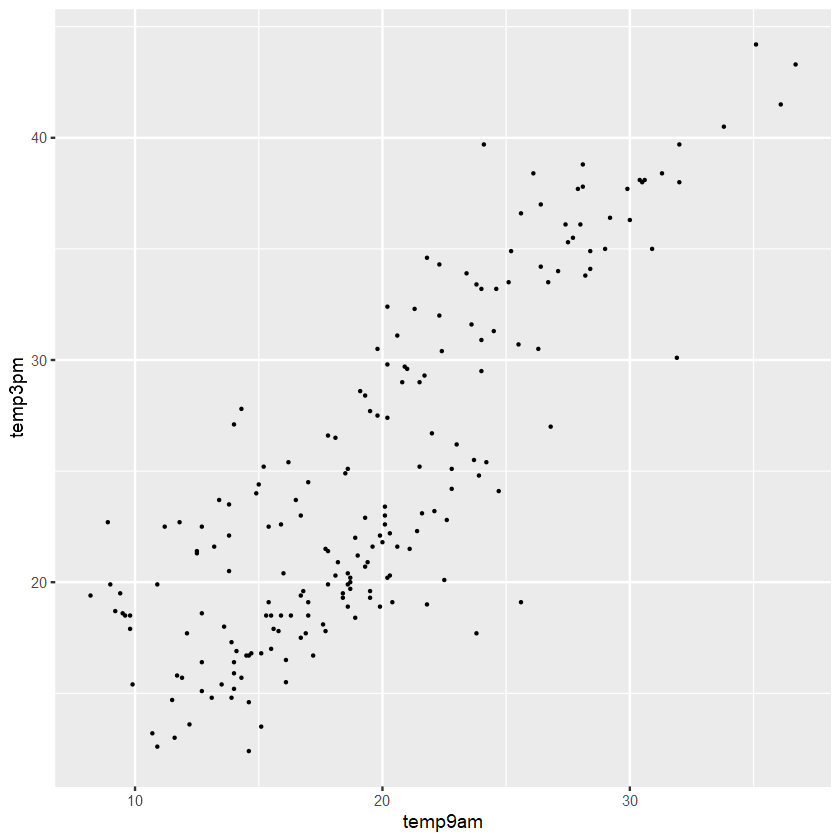

In [8]:
ggplot(weather_WU, aes(x = temp9am, y = temp3pm)) +
  geom_point(size = 0.2)

<br>

### MCMC 시뮬레이션

In [ ]:
weather_model_1 <- stan_glm(
  temp3pm ~ temp9am, 
  data = weather_WU, family = gaussian,
  prior_intercept = normal(25, 5),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)

<br>

### autoscale된 사전분포

In [10]:
prior_summary(weather_model_1)

Priors for model 'weather_model_1' 
------
Intercept (after predictors centered)
 ~ normal(location = 25, scale = 5)

Coefficients
  Specified prior:
    ~ normal(location = 0, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 0, scale = 3.1)

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.13)
------
See help('prior_summary.stanreg') for more details



$$\begin{equation}
\begin{split}
Y_i | \beta_0, \beta_1, \sigma & \stackrel{ind}{\sim} N\left(\mu_i, \sigma^2\right) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_{i1} \\
\beta_{0c}& \sim N\left(25, 5^2\right)  \\
\beta_1    & \sim N\left(0, 3.1^2\right) \\
\sigma     & \sim \text{Exp}(0.13)  .\\
\end{split}
\end{equation}$$

<br>

### 시뮬레이션 결과 확인

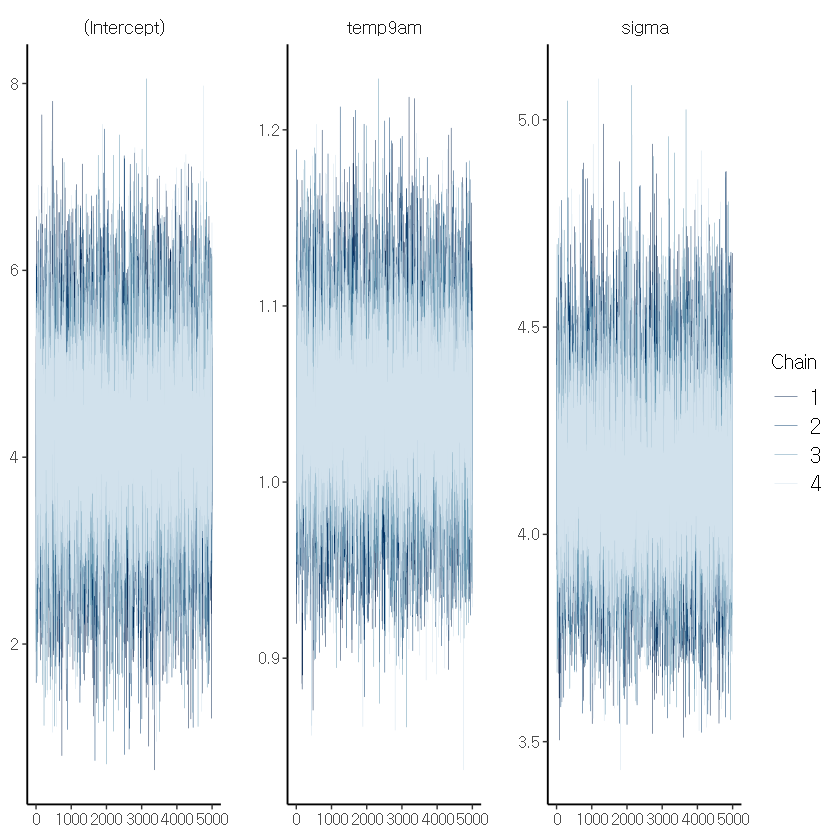

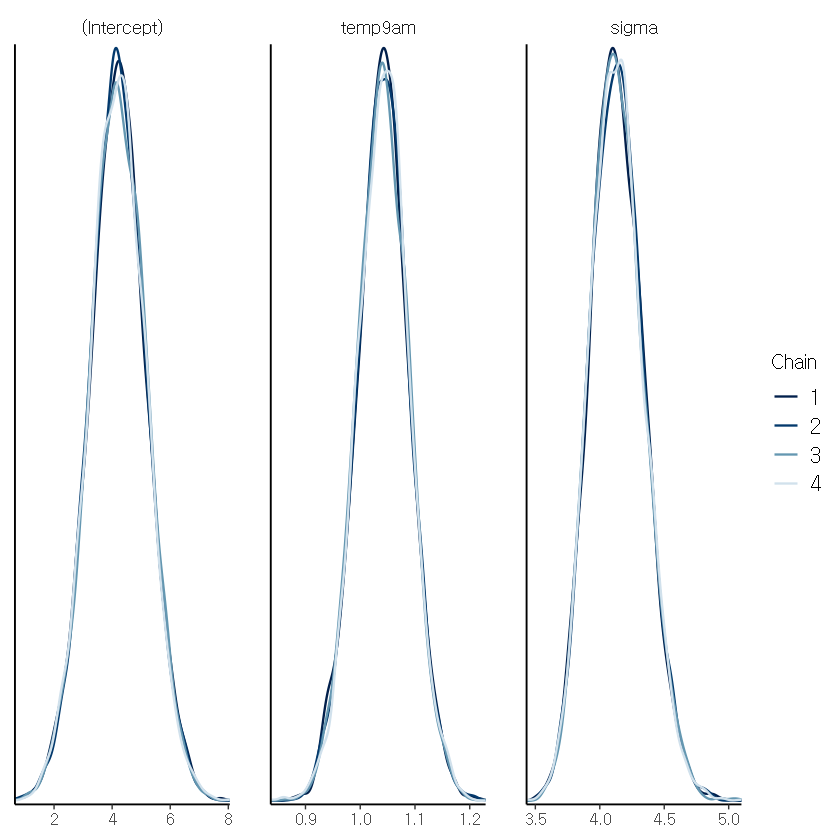

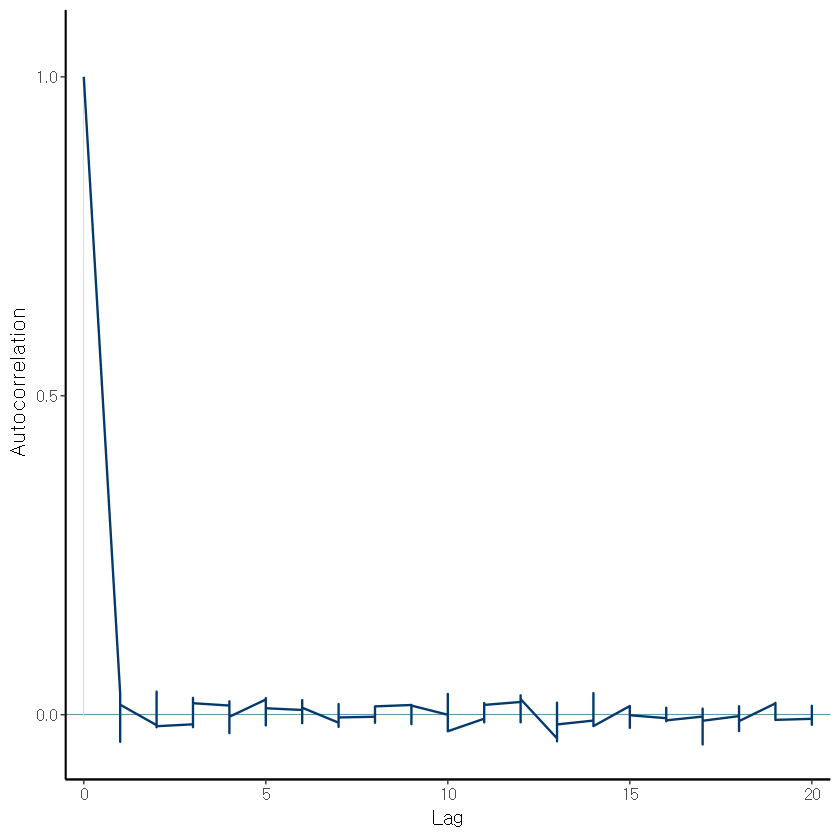

In [12]:
mcmc_trace(weather_model_1, size = 0.1)
mcmc_dens_overlay(weather_model_1)
mcmc_acf(weather_model_1)

In [13]:
neff_ratio(weather_model_1)
rhat(weather_model_1)

(Intercept)     temp9am       sigma 
    0.99710     1.00255     0.94530

(Intercept)     temp9am       sigma 
  0.9999352   0.9999668   0.9999059

<br>

### 매개변수별 사후분포 통계량

In [26]:
tidy(weather_model_1, effects = c("fixed", "aux"),
     conf.int = TRUE, conf.level = 0.80) %>% 
  select(-std.error)

term,estimate,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>
(Intercept),4.200097,2.9498083,5.448752
temp9am,1.042184,0.9802648,1.102423
sigma,4.128480,3.8739305,4.409474
mean_PPD,24.558183,24.0287753,25.085335


<br>

### 사후예측분포 검사

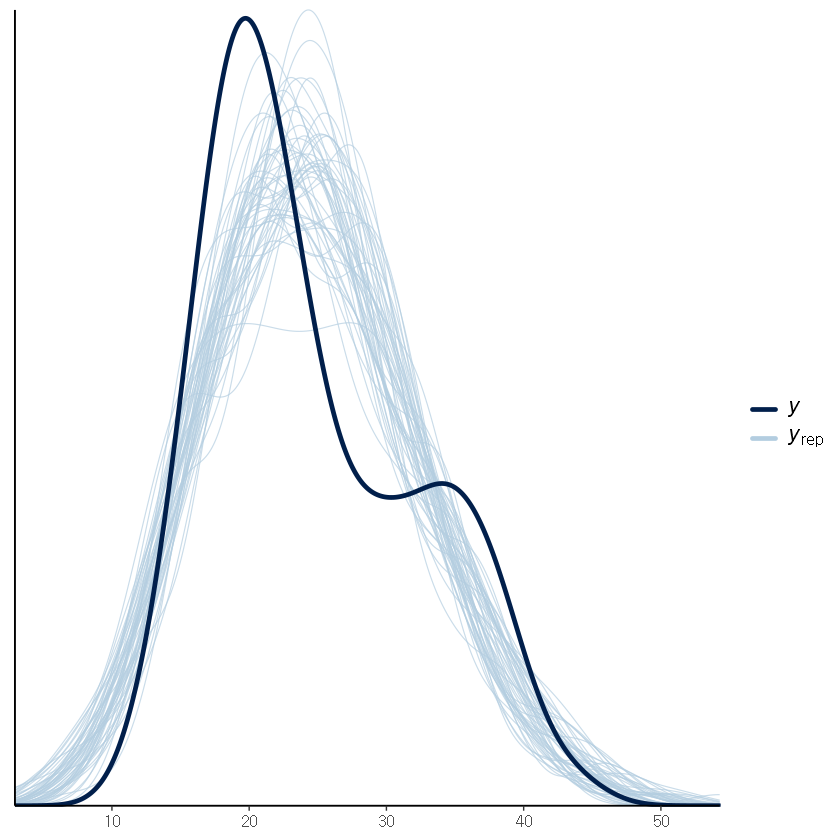

In [15]:
pp_check(weather_model_1)

<br>

## 11.01. 범주형 변수

<br>

#### 범주형 변수의 값마다, 반응변수의 분포의 차이가 큼

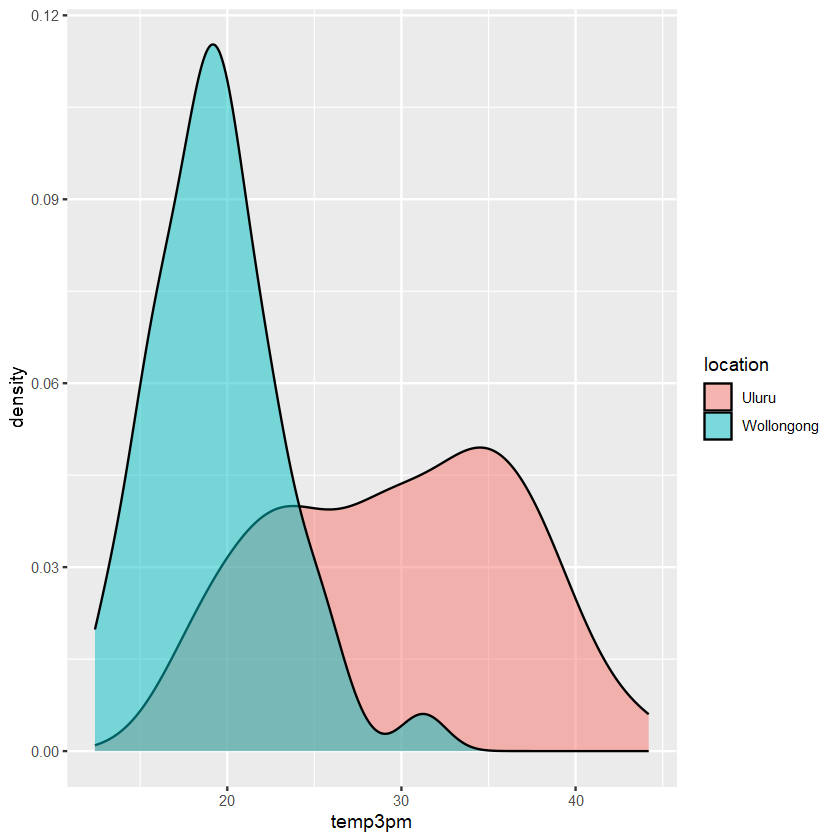

In [16]:
ggplot(weather_WU, aes(x = temp3pm, fill = location)) + 
  geom_density(alpha = 0.5)

<br>

### 범주형 변수의 가변수화
$$X_{i2} = \begin{cases}
1 & \text{ Wollongong} \\
0 & \text{ otherwise (i.e., Uluru).} \\
\end{cases}$$

<br>

$$\mu_i = \beta_0 + \beta_1 X_{i2}$$가정하에, 

$$X_{i2} = 0\;\;\rightarrow \;\;\beta_0 + \beta_1 \cdot 0 = \beta_0  .$$

$$X_{i2} = 1\;\;\rightarrow \;\;\beta_0 + \beta_1 \cdot 1 = \beta_0 + \beta_1  .$$

<br>

#### MCMC 시뮬레이션

In [ ]:
weather_model_2 <- stan_glm(
  temp3pm ~ location,
  data = weather_WU, family = gaussian,
  prior_intercept = normal(25, 5),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)

<br>

#### autoscale된  사전분포

In [19]:
prior_summary(weather_model_2)

Priors for model 'weather_model_2' 
------
Intercept (after predictors centered)
 ~ normal(location = 25, scale = 5)

Coefficients
  Specified prior:
    ~ normal(location = 0, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 0, scale = 38)

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.13)
------
See help('prior_summary.stanreg') for more details


$$\begin{equation}
\begin{array}{lcrl} 
\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1 X_{i2}\\
\text{priors:} & & \beta_{0c}  &  \sim N\left(25, 5^2\right)  \\
                     & & \beta_1  & \sim N\left(0, 38^2 \right) \\
                     & & \sigma & \sim \text{Exp}(0.13)  .\\
\end{array}
\end{equation}$$

<br>

### 시뮬레이션 결과 확인

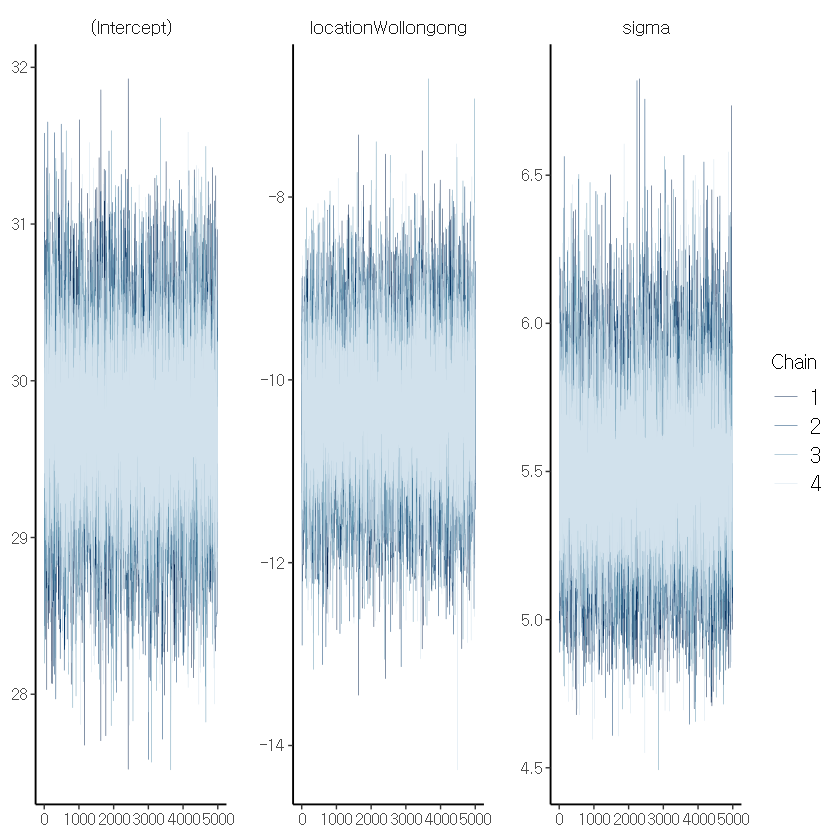

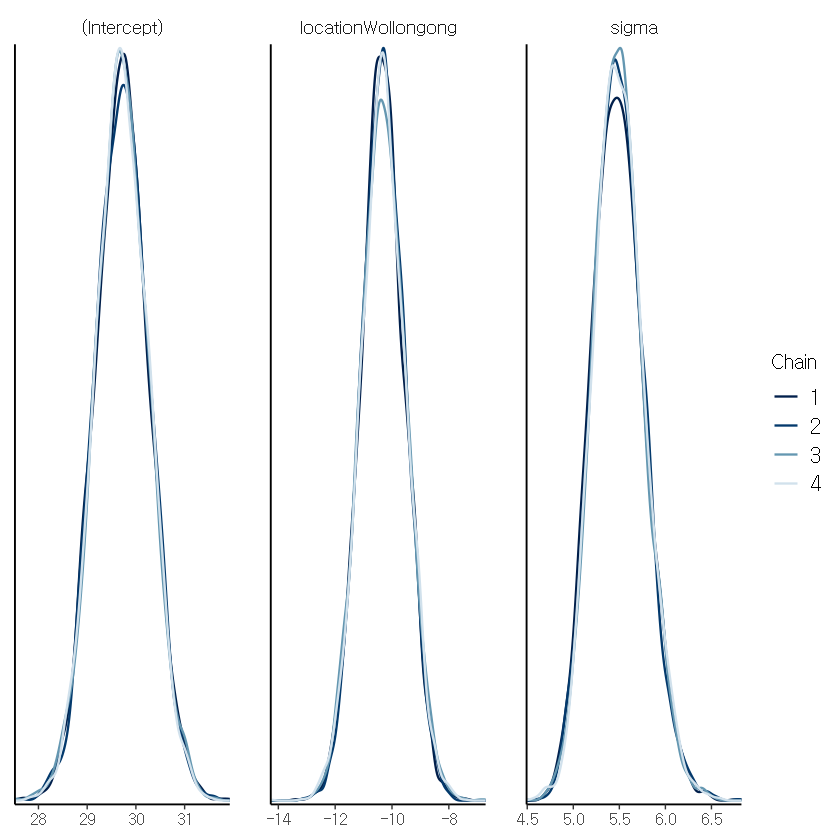

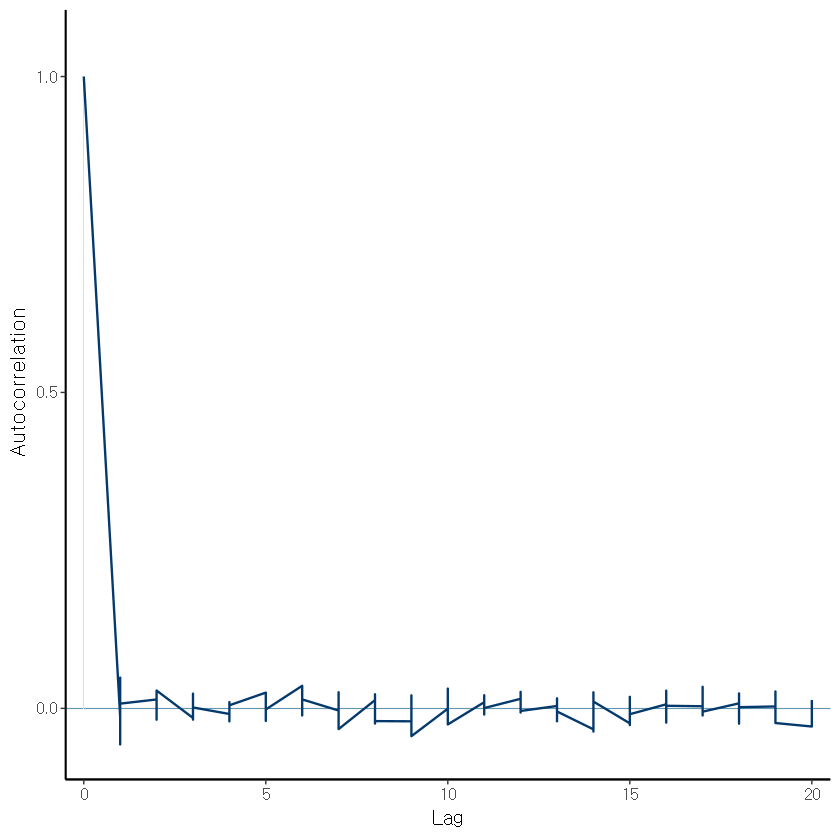

In [20]:
mcmc_trace(weather_model_2, size = 0.1)
mcmc_dens_overlay(weather_model_2)
mcmc_acf(weather_model_2)

<br>

### 매개변수별 사후분포 통계량

In [25]:
tidy(weather_model_2, effects = c("fixed", "aux"),
     conf.int = TRUE, conf.level = 0.80) %>% 
  select(-std.error)

term,estimate,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>
(Intercept),29.714695,29.01943,30.424971
locationWollongong,-10.322937,-11.31883,-9.301761
sigma,5.484104,5.14486,5.857824
mean_PPD,24.564554,23.85914,25.261738


<br>

### 범주형 변수 값에 따른 사후분포 차이

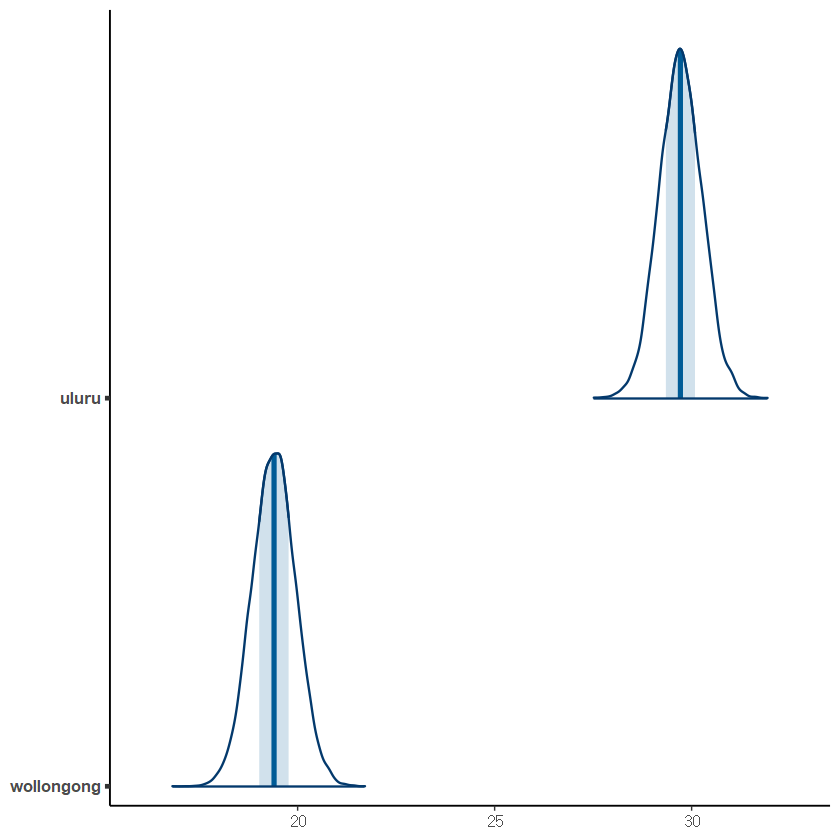

In [22]:
as.data.frame(weather_model_2) %>% 
  mutate(uluru = `(Intercept)`, 
         wollongong = `(Intercept)` + locationWollongong) %>% 
  mcmc_areas(pars = c("uluru", "wollongong"))

<br>

## 11.02. 다항회귀


### MCMC 시뮬레이션을 통한 사전분포 autoscale

In [ ]:
weather_model_3_prior <- stan_glm(
  temp3pm ~ temp9am + location,
  data = weather_WU, family = gaussian, 
  prior_intercept = normal(25, 5),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735,
  prior_PD = TRUE)

In [32]:
prior_summary(weather_model_3_prior)

Priors for model 'weather_model_3_prior' 
------
Intercept (after predictors centered)
 ~ normal(location = 25, scale = 5)

Coefficients
  Specified prior:
    ~ normal(location = [0,0], scale = [2.5,2.5])
  Adjusted prior:
    ~ normal(location = [0,0], scale = [ 3.11,37.52])

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.13)
------
See help('prior_summary.stanreg') for more details

$$\begin{equation}
\begin{array}{lcrl} 
\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\beta_2,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2)  \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} \\
\text{priors:} & & \beta_{0c}  &  \sim N\left(25, 5^2 \right)  \\
                     & & \beta_1  & \sim N\left(0, 3.11^2 \right) \\
                     & & \beta_2  & \sim N\left(0, 37.52^2 \right) \\
                     & & \sigma & \sim \text{Exp}(0.13)  .\\
\end{array}
\end{equation}$$

<br>

### 시뮬레이션  결과 확인
#### 마르코프 체인의 값들이 넓은 범위를 가짐 $\rightarrow$ 추정량에 대한 불확실성이 높음

In [40]:
head(as.data.frame(weather_model_3_prior), 3)

,(Intercept),temp9am,locationWollongong,sigma
,<dbl>,<dbl>,<dbl>,<dbl>
1,11.76180,-0.5501849,51.40185,3.632309
2,19.88667,0.1397291,15.50575,20.162488
3,-19.05237,2.1745951,15.61010,6.999850


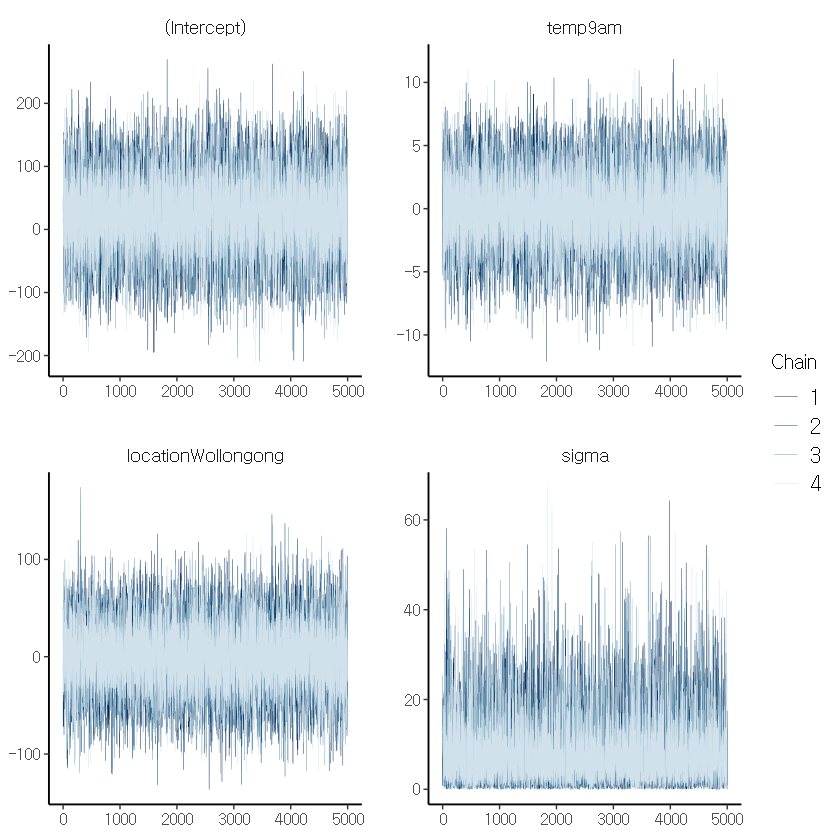

In [43]:
mcmc_trace(weather_model_3_prior, size = 0.1)

<br>

Warning message:
"
In add_predicted_draws(): The `n` argument is a deprecated alias for `ndraws`.
Use the `ndraws` argument instead.
See help("tidybayes-deprecated").
"
Warning message:
"`fitted_draws` and `add_fitted_draws` are deprecated as their names were confusing.
- Use [add_]epred_draws() to get the expectation of the posterior predictive.
- Use [add_]linpred_draws() to get the distribution of the linear predictor.
- For example, you used [add_]fitted_draws(..., scale = "response"), which
  means you most likely want [add_]epred_draws(...).
NOTE: When updating to the new functions, note that the `model` parameter is now
  named `object` and the `n` parameter is now named `ndraws`."


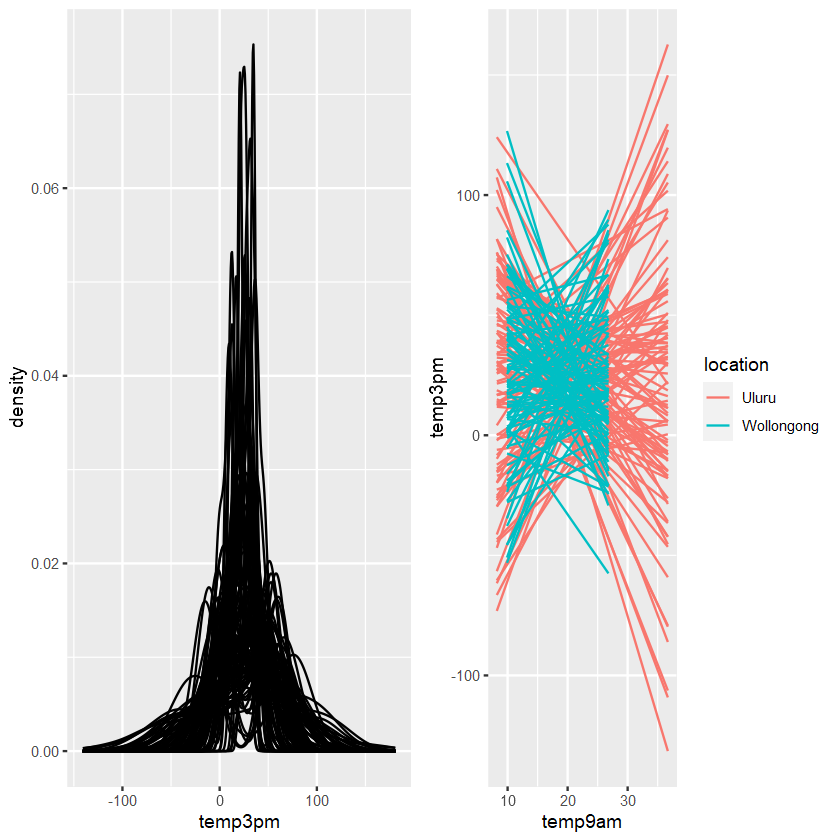

In [31]:
set.seed(84735)

weather_WU %>%
  add_predicted_draws(weather_model_3_prior, n = 100) %>%
  ggplot(aes(x = .prediction, group = .draw)) +
    geom_density() + 
    xlab("temp3pm") -> p1

weather_WU %>%
  add_fitted_draws(weather_model_3_prior, n = 100) %>%
  ggplot(aes(x = temp9am, y = temp3pm, color = location)) +
    geom_line(aes(y = .value, group = paste(location, .draw))) -> p2

gridExtra::grid.arrange(p1, p2, nrow=1)

<br>

#### 따라서, autoscale된 사전분포로 모형을 업데이트 

In [ ]:
weather_model_3 <- update(weather_model_3_prior, prior_PD = FALSE)

In [34]:
head(as.data.frame(weather_model_3), 3)

,(Intercept),temp9am,locationWollongong,sigma
,<dbl>,<dbl>,<dbl>,<dbl>
1,13.04657,0.8016891,-7.663020,2.392109
2,12.73136,0.8174191,-7.838690,2.444850
3,11.81295,0.8615380,-7.647937,2.413606


Warning message:
"`fitted_draws` and `add_fitted_draws` are deprecated as their names were confusing.
- Use [add_]epred_draws() to get the expectation of the posterior predictive.
- Use [add_]linpred_draws() to get the distribution of the linear predictor.
- For example, you used [add_]fitted_draws(..., scale = "response"), which
  means you most likely want [add_]epred_draws(...).
NOTE: When updating to the new functions, note that the `model` parameter is now
  named `object` and the `n` parameter is now named `ndraws`."


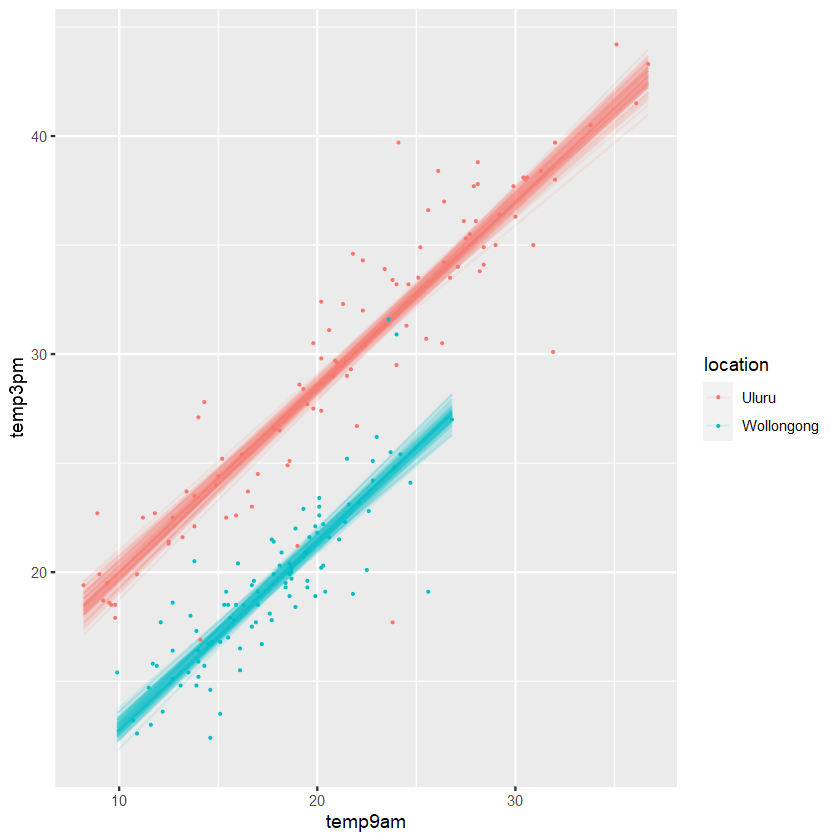

In [38]:
weather_WU %>%
  add_fitted_draws(weather_model_3, n = 100) %>%
  ggplot(aes(x = temp9am, y = temp3pm, color = location)) +
    geom_line(aes(y = .value, group = paste(location, .draw)), alpha = .1) +
    geom_point(data = weather_WU, size = 0.1)

<br>

#### 매개변수별 사후분포의 신용구간

In [39]:
posterior_interval(weather_model_3, prob = 0.80, 
                   pars = c("temp9am", "locationWollongong"))

,10%,90%
temp9am,0.8196281,0.8945346
locationWollongong,-7.5067716,-6.5999057


<br>

### 사후예측분포
#### 새로운 관측값

In [50]:
data.frame(temp9am = c(10, 10), 
                       location = c("Uluru", "Wollongong"))

temp9am,location
<dbl>,<chr>
10,Uluru
10,Wollongong


<br>

#### 새로운 관측값에 대한 사후예측분포

In [48]:
set.seed(84735)
temp3pm_prediction <- posterior_predict(
  weather_model_3,
  newdata = data.frame(temp9am = c(10, 10), 
                       location = c("Uluru", "Wollongong")))

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


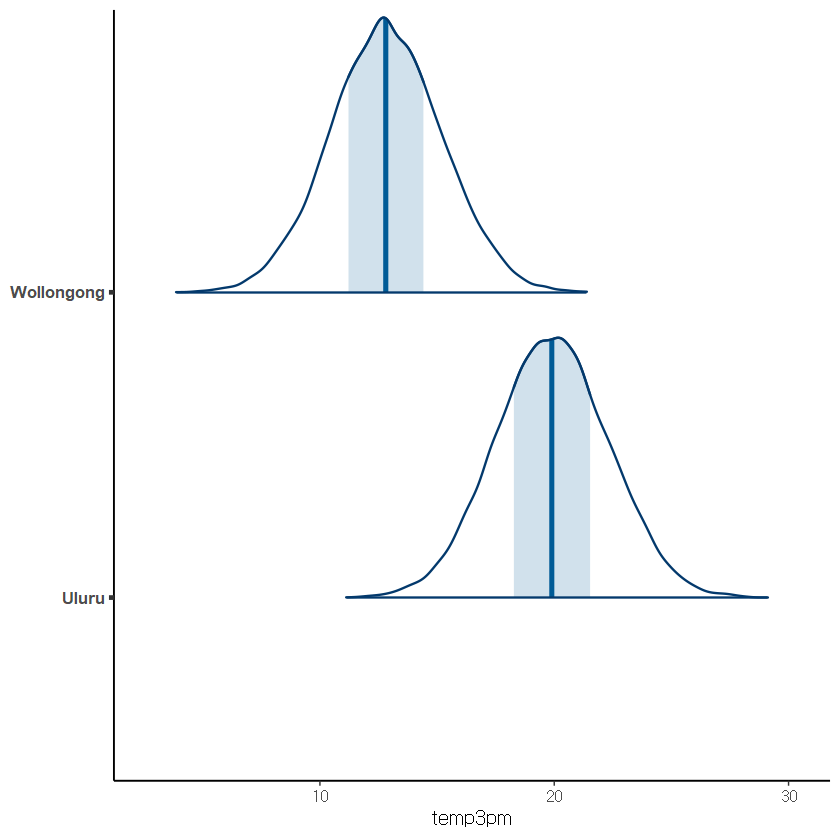

In [45]:
mcmc_areas(temp3pm_prediction) +
  ggplot2::scale_y_discrete(labels = c("Uluru", "Wollongong")) + 
  xlab("temp3pm")

<br>

## 11.03. 상호작용항

$$\mu = \beta_0 + \beta_1 X_{2} + \beta_2 X_{3} + \beta_3 X_{2}X_{3}  .$$

### autoscale된 사전분포

In [ ]:
interaction_model <- stan_glm(
  temp3pm ~ location + humidity9am + location:humidity9am, 
  data = weather_WU, family = gaussian,
  prior_intercept = normal(25, 5),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)

In [52]:
prior_summary(interaction_model)

Priors for model 'interaction_model' 
------
Intercept (after predictors centered)
 ~ normal(location = 25, scale = 5)

Coefficients
  Specified prior:
    ~ normal(location = [0,0,0], scale = [2.5,2.5,2.5])
  Adjusted prior:
    ~ normal(location = [0,0,0], scale = [37.52, 0.82, 0.55])

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.13)
------
See help('prior_summary.stanreg') for more details

$$\begin{equation}
\begin{array}{lcrl} 
\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\beta_2,\beta_3,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2) \;\; \text{ with } \; \mu_i = \beta_0 + \beta_1X_{i2} + \beta_2X_{i3} + \beta_3X_{i2}X_{i3} \\
\text{priors:} & & \beta_{0c}  &  \sim N\left(25, 5^2 \right)  \\
                     & & \beta_1  & \sim N\left(0, 37.52^2 \right) \\
                     & & \beta_2  & \sim N\left(0, 0.82^2 \right) \\
                     & & \beta_3  & \sim N\left(0, 0.55^2 \right) \\
                     & & \sigma & \sim \text{Exp}(0.13)  .\\
\end{array}
\end{equation}$$

<br>

### 매개변수 사후분포의 통계량 (=매개변수 추정량)

$$\begin{array}{lrl}
\text{Uluru:}      & \mu & =  37.586 - 0.19 \text{ humidity9am} \\
\text{Wollongong:} & \mu & = (37.586 - 21.842) + (-0.19 + 0.246) \text{ humidity9am}\\
&& = 15.707 + 0.056 \text{ humidity9am}\\
\end{array}$$

In [60]:
tidy(interaction_model, effects = c("fixed", "aux"),
     conf.int = TRUE, conf.level = 0.80)

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),37.5859071,0.90920449,36.4323688,38.7455798
locationWollongong,-21.8428042,2.30805845,-24.7955606,-18.8419905
humidity9am,-0.1898744,0.01930495,-0.2141650,-0.1651750
locationWollongong:humidity9am,0.2456051,0.03715427,0.1977762,0.2930092
sigma,4.4723319,0.22918418,4.1921008,4.7774931
mean_PPD,24.5586385,0.45328502,23.9768386,25.1416855


<br>

### 상호작용항에 대한 매개변수 사후분포의 신용구간

In [57]:
posterior_interval(interaction_model, prob = 0.80, 
                   pars = "locationWollongong:humidity9am")

,10%,90%
locationWollongong:humidity9am,0.1977762,0.2930092


<br>



Warning message:
"`fitted_draws` and `add_fitted_draws` are deprecated as their names were confusing.
- Use [add_]epred_draws() to get the expectation of the posterior predictive.
- Use [add_]linpred_draws() to get the distribution of the linear predictor.
- For example, you used [add_]fitted_draws(..., scale = "response"), which
  means you most likely want [add_]epred_draws(...).
NOTE: When updating to the new functions, note that the `model` parameter is now
  named `object` and the `n` parameter is now named `ndraws`."


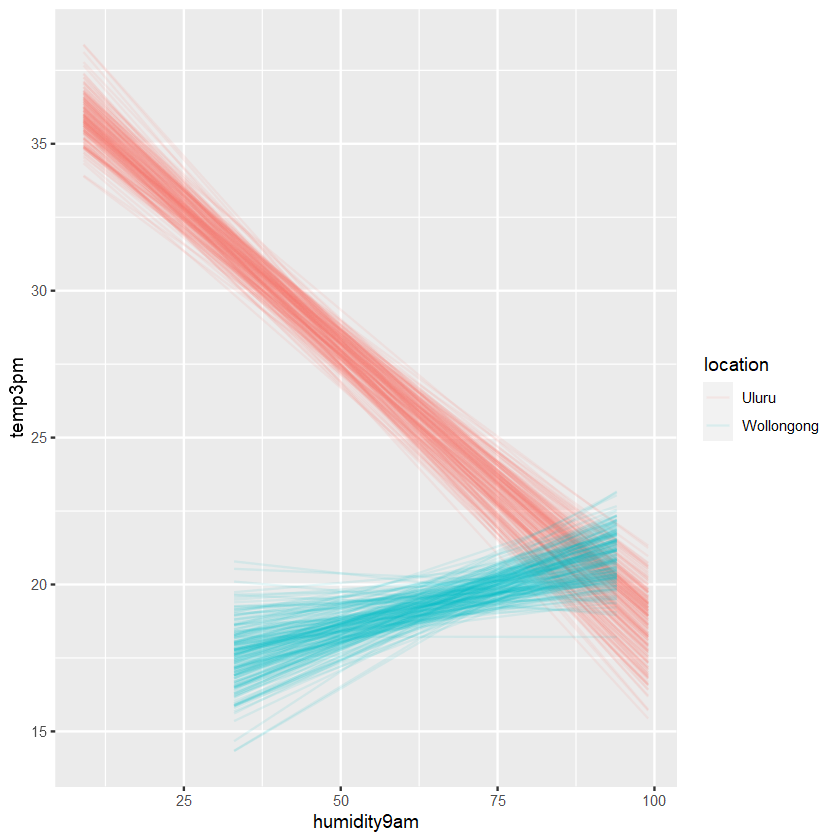

In [61]:
weather_WU %>%
  add_fitted_draws(interaction_model, n = 200) %>%
  ggplot(aes(x = humidity9am, y = temp3pm, color = location)) +
    geom_line(aes(y = .value, group = paste(location, .draw)), alpha = 0.1)

<br>

### 상호작용항의 추가는 신중히 결정

<br>

## 11.04. 더 많은 설명변수에 의한 회귀모형

### autoscale된 사전분포

In [ ]:
weather_model_4 <- stan_glm(
  temp3pm ~ .,
  data = weather_WU, family = gaussian, 
  prior_intercept = normal(25, 5),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)

In [73]:
prior_summary(weather_model_4)

Priors for model 'weather_model_4' 
------
Intercept (after predictors centered)
 ~ normal(location = 25, scale = 5)

Coefficients
  Specified prior:
    ~ normal(location = [0,0,0,...], scale = [2.5,2.5,2.5,...])
  Adjusted prior:
    ~ normal(location = [0,0,0,...], scale = [37.52, 2.37, 0.82,...])

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.13)
------
See help('prior_summary.stanreg') for more details

$$$$\begin{equation}
\begin{array}{lcrl} 
\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\ldots,\beta_5,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_{i1} + \cdots + \beta_5X_{i5} \\
\text{priors:} & & \beta_{0c} & \sim N(25, 5^2) \\
 && \beta_1, \ldots, \beta_5  & \sim N(0, \text{(some weakly informative sd)}^2) \\
                     & & \sigma & \sim \text{Exp}(0.13)  .\\
\end{array}
\end{equation}$$$$

<br>

### 시뮬레이션 결과 확인

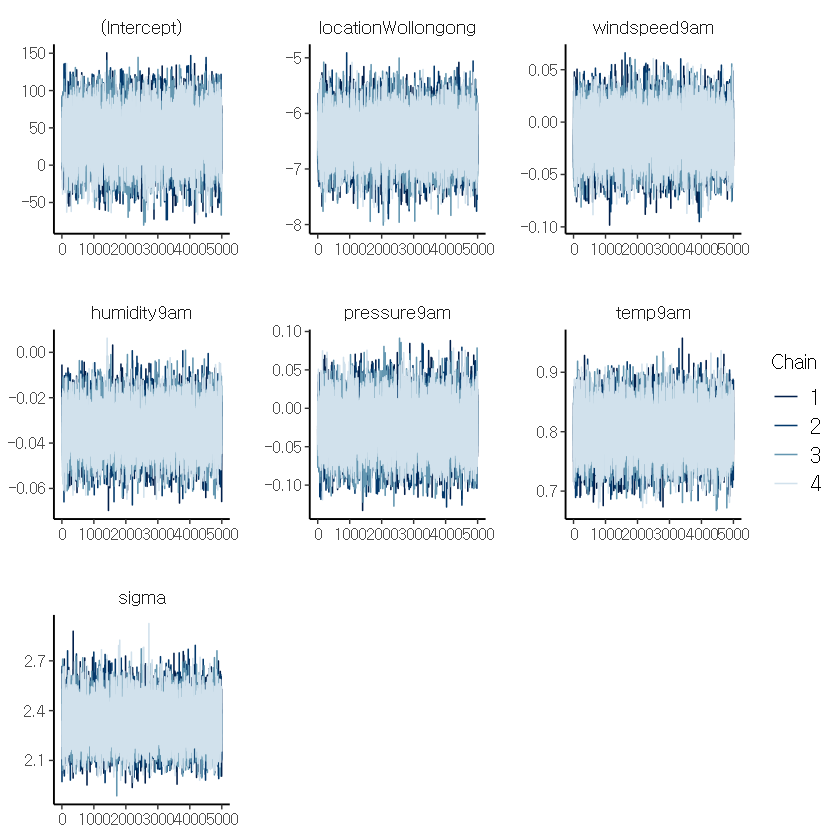

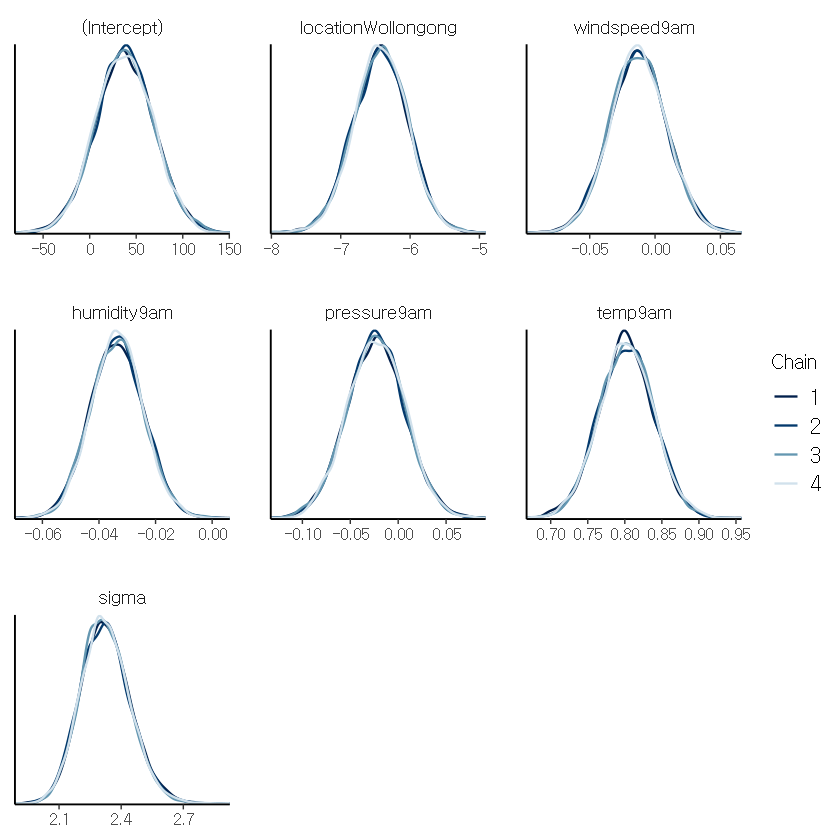

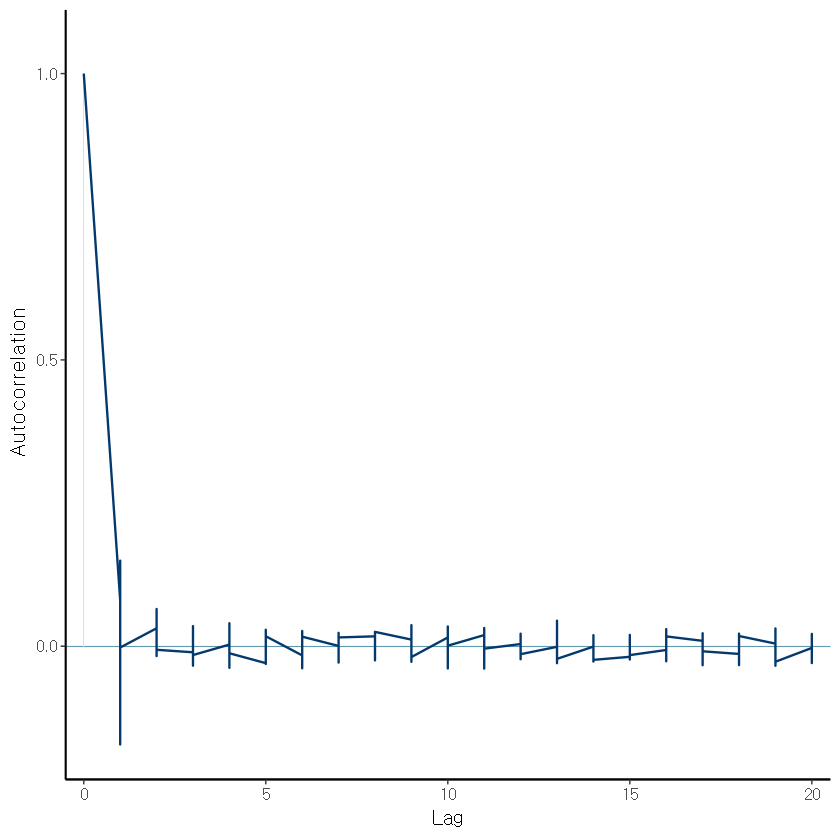

In [74]:
mcmc_trace(weather_model_4)
mcmc_dens_overlay(weather_model_4)
mcmc_acf(weather_model_4)

<br>

### 매개변수별 사후분포의 신용구간

In [75]:
posterior_interval(weather_model_4, prob = 0.95)

,2.5%,97.5%
(Intercept),-23.92281904,98.96184755
locationWollongong,-7.19827046,-5.66547243
windspeed9am,-0.05491239,0.02975158
humidity9am,-0.05169826,-0.01510501
pressure9am,-0.08255876,0.03669673
temp9am,0.72892547,0.87455883
sigma,2.10496742,2.57179996


<br>

## 11.05. 모델평가 & 비교

<table>
<thead>
<tr class="header">
<th align="left">Model</th>
<th align="left">Formula</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td align="left"><code>weather_model_1</code></td>
<td align="left"><code>temp3pm ~ temp9am</code></td>
</tr>
<tr class="even">
<td align="left"><code>weather_model_2</code></td>
<td align="left"><code>temp3pm ~ location</code></td>
</tr>
<tr class="odd">
<td align="left"><code>weather_model_3</code></td>
<td align="left"><code>temp3pm ~ temp9am + location</code></td>
</tr>
<tr class="even">
<td align="left"><code>weather_model_4</code></td>
<td align="left"><code>temp3pm ~ .</code></td>
</tr>
</tbody>
</table>

<br>

### 각 모형별 사후예측분포 검사

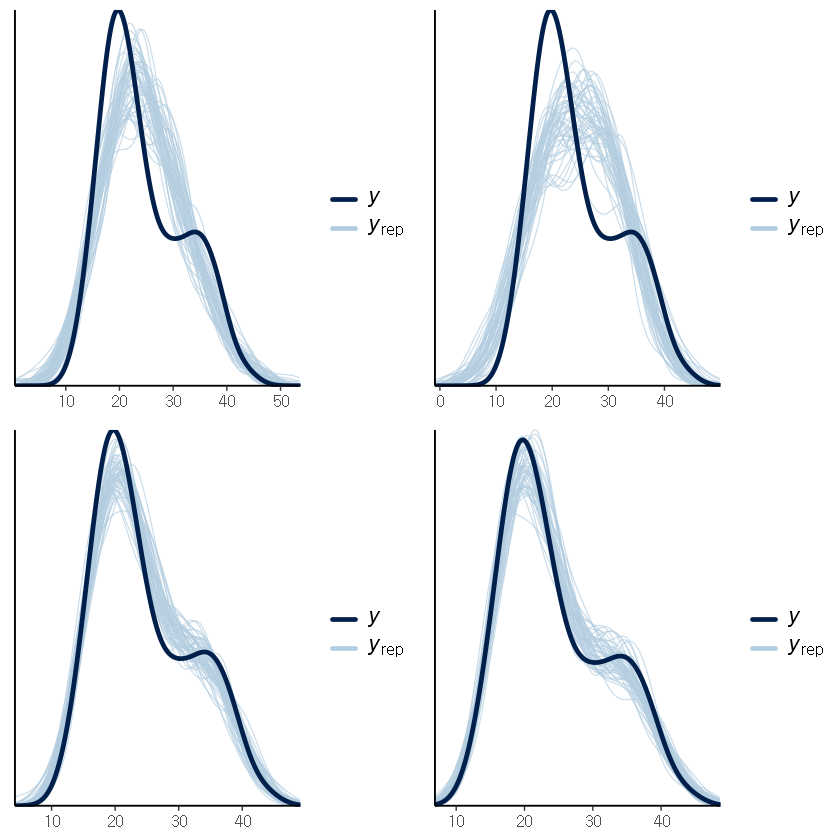

In [76]:
pp_check(weather_model_1) -> p1
pp_check(weather_model_2) -> p2
pp_check(weather_model_3) -> p3
pp_check(weather_model_4) -> p4

gridExtra::grid.arrange(p1,p2,p3, p4, nrow = 2)

<br>

### 시각화를 통한 모형비교
- **시각화를 통한 모형비교는 4번째 모형과 같은 복잡한 모형에 대해서 제한됨**
- **신규 관측값에 대한 예측력의 평가보다는, 기존의 관측값 (학습 데이터)에 대한 예측 정확도만 평가 가능**

In [87]:
set.seed(84735)
predictions_1 <- posterior_predict(weather_model_1, newdata = weather_WU)
predictions_2 <- posterior_predict(weather_model_2, newdata = weather_WU)
predictions_3 <- posterior_predict(weather_model_3, newdata = weather_WU)
predictions_4 <- posterior_predict(weather_model_4, newdata = weather_WU)

<br>

#### 3번쨰 모델 (상호작용항)이 1과 2보다 더 높은 예측 정확도를 가짐

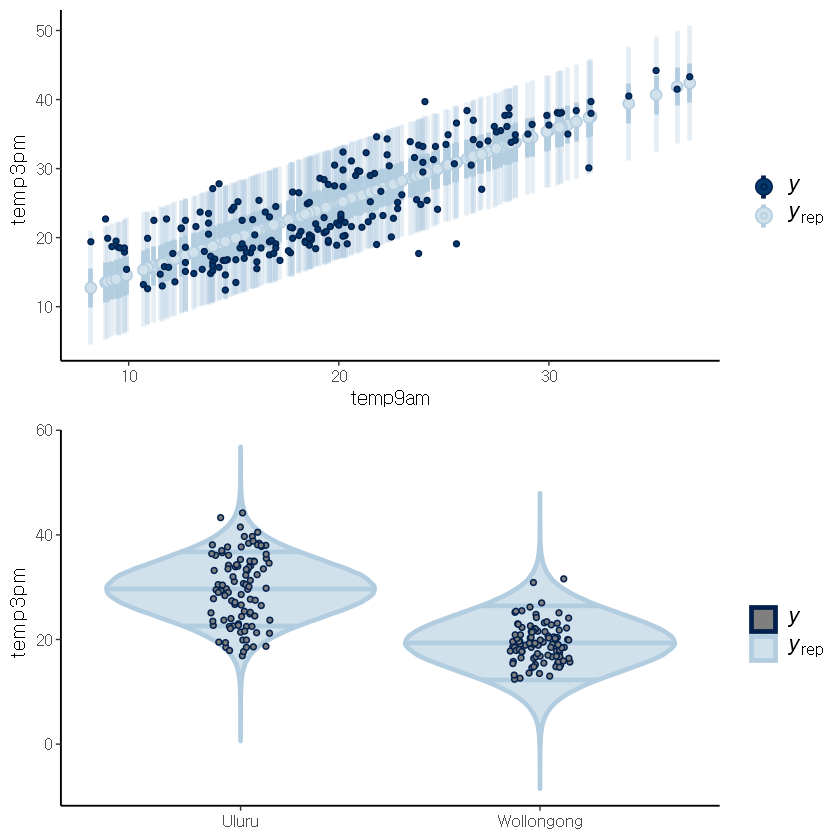

In [88]:
ppc_intervals(weather_WU$temp3pm, yrep = predictions_1, 
              x = weather_WU$temp9am, prob = 0.5, prob_outer = 0.95) + 
  labs(x = "temp9am", y = "temp3pm") -> p1

ppc_violin_grouped(weather_WU$temp3pm, yrep = predictions_2, 
                   group = weather_WU$location, y_draw = "points") + 
  labs(y = "temp3pm") -> p2

gridExtra::grid.arrange(p1, p2)

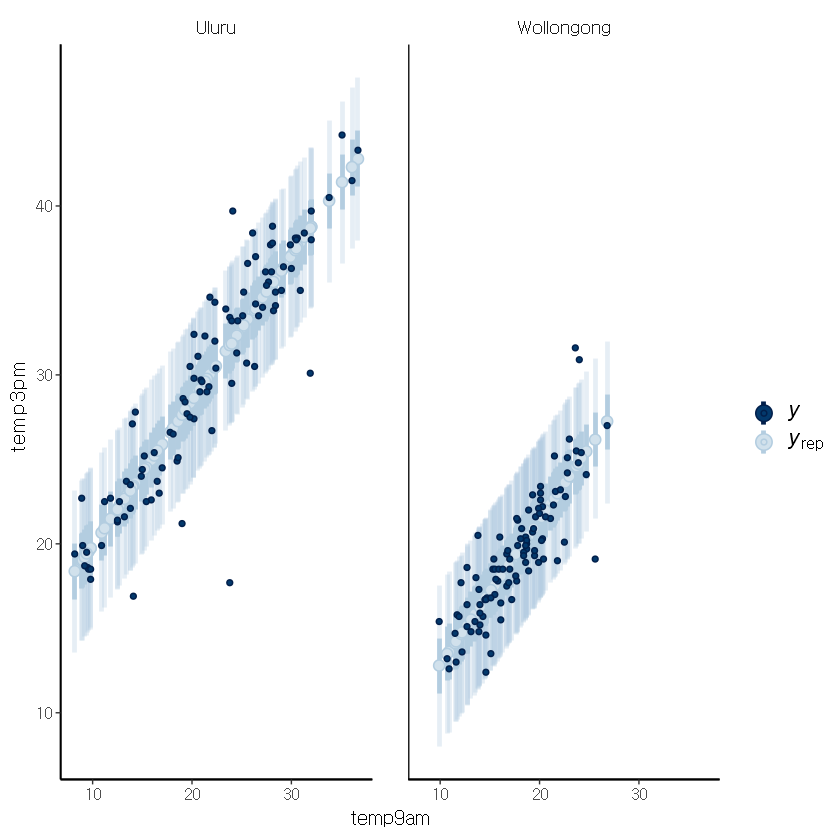

In [89]:
ppc_intervals_grouped(weather_WU$temp3pm, yrep = predictions_3, 
                      x = weather_WU$temp9am, group = weather_WU$location,
                      prob = 0.5, prob_outer = 0.95,
                      facet_args = list(scales = "fixed")) + 
  labs(x = "temp9am", y = "temp3pm")

<br>

### 교차검증을 통한 평가
- 3번째 모델이 가장 높은 예측 정확도를 가짐

In [91]:
set.seed(84735)
prediction_summary_cv(model = weather_model_1, data = weather_WU, k = 10)$cv
prediction_summary_cv(model = weather_model_2, data = weather_WU, k = 10)$cv
prediction_summary_cv(model = weather_model_3, data = weather_WU, k = 10)$cv
prediction_summary_cv(model = weather_model_4, data = weather_WU, k = 10)$cv

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
3.284901,0.7895262,0.405,0.97


mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
3.778304,0.6807291,0.52,0.935


mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
1.094242,0.4581253,0.655,0.96


mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
1.159198,0.4945366,0.63,0.95


<br>

### ELPD를 통한 평가
- **ELPD는 사후예측분포의 정확도에 대해 해석가능한 측정항목을 제공하지 않지만, 여러 모델의 사후예측분포 정확도를 비교하는 데 유용**

> $ELPD_1$과 $ELPD_2$가 모형 1과 2의 ELPD 추정치고, $\text{se}_{\text{diff}}$가 ELPD 추정치간 차이($\text{ELPD}_2 - \text{ELPD}_1$)의 표준오차를 나타낼 때,
>
> **다음과 같은 경우에서, 모델 1의 사후예측분포 정확도는 모델 2의 정확도보다 명확히 더 높음**
>
> 1. $\text{ELPD}_1 > \text{ELPD}_2$이고
>
> 2. $ELPD_2$가 $ELPD_1$보다 $2\times \text{se}_{\text{diff}}$작을 때
> 
>  ($(\text{ELPD}_2 - \text{ELPD}_1) + 2\text{se}_{\text{diff}} < 0$)

<br>


In [92]:
loo_1 <- loo(weather_model_1)
loo_2 <- loo(weather_model_2)
loo_3 <- loo(weather_model_3)
loo_4 <- loo(weather_model_4)

c(loo_1$estimates[1], loo_2$estimates[1], loo_3$estimates[1], loo_4$estimates[1])

Warning message:
"Found 1 observation(s) with a pareto_k > 0.7. We recommend calling 'loo' again with argument 'k_threshold = 0.7' in order to calculate the ELPD without the assumption that these observations are negligible. This will refit the model 1 times to compute the ELPDs for the problematic observations directly.
"


[1] -568.4233 -625.7383 -461.0916 -457.6155

<br>

#### `loo_compare()` :  모형들의 ELPD를 비교

In [93]:
loo_compare(loo_1, loo_2, loo_3, loo_4)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
weather_model_4,0.000000,0.000000,-457.6155,22.052865,10.563203,3.8596812,915.2309,44.10573
weather_model_3,-3.476123,4.000419,-461.0916,22.978735,7.484305,3.4509624,922.1831,45.95747
weather_model_1,-110.807887,18.104809,-568.4233,8.565565,2.541776,0.3475452,1136.8467,17.13113
weather_model_2,-168.122838,21.516920,-625.7383,9.517648,2.891026,0.3229537,1251.4766,19.03530


<br>

### 분산-편향 Trade Off
> **사용되는 데이터와 관계없이 추정치가 일관적인 경향을 가지는 경우 $\rightarrow$ '모형의 편향이 높음'**
>
> **사용되는 데이터에 따라 추정치가 크게 달라지는 경우 $\rightarrow$ '예측분산이 높음'**


> 반응변수가 거의 없거나, 지나치게 단순한 모델은, 편향은 높지만 예측분산은 낮은 경향 (높은 안정성)
>> **높은 편향은 과소적합을 유발하여, 기존 관측값에 대한 낮은 예측 성능으로 연결**


> 많은 예측 변수가 포함된 지나치게 복잡한 모델은, 편향이 낮지만 예측분산이 높은 경향 (낮은 안정성)
>> **높은 분산은 과대적합을 유발하여, 새로운 관측값에 대한 낮은 예측 성능으로 연결**


> **좋은 모형은 편향과 예측 분산 모두가 낮은 모형**

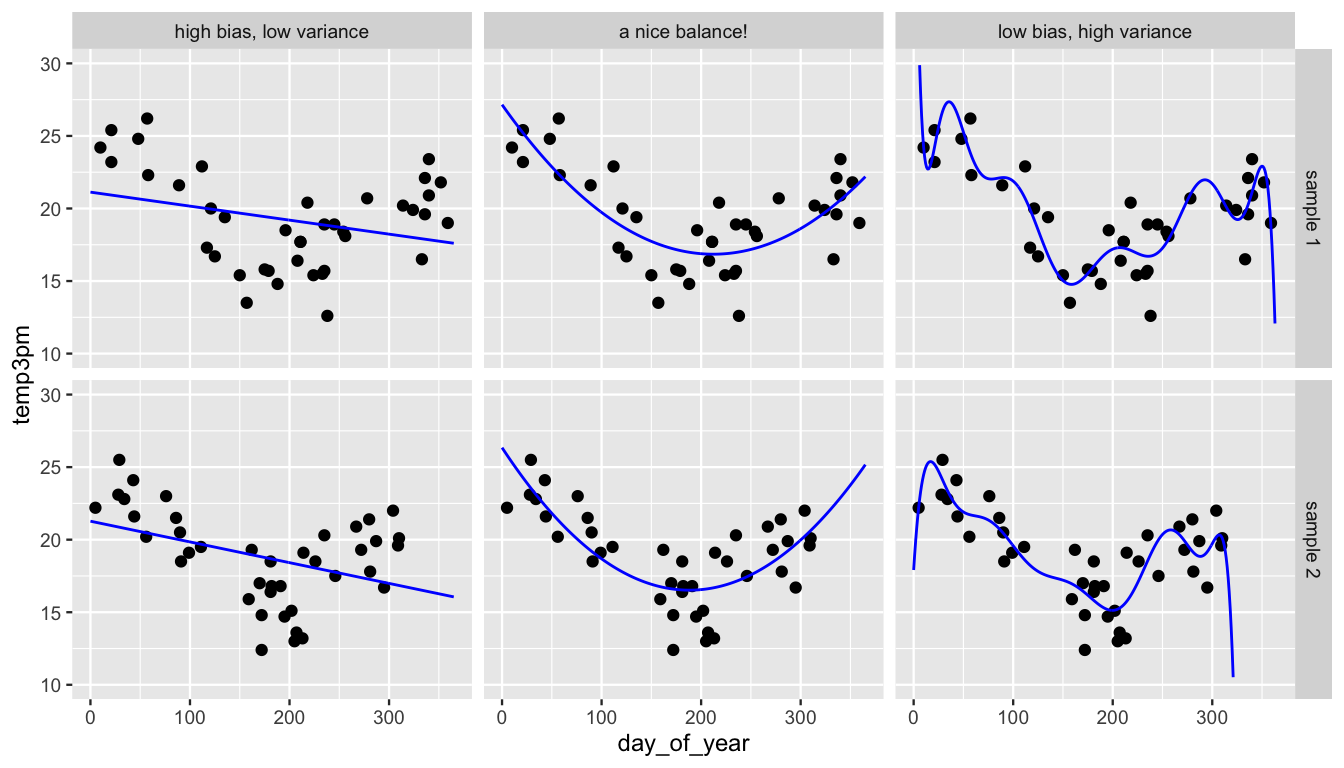